In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel('../dataset/clean_dataset++.xlsx')
data = data.sample(frac = 1, random_state=7).reset_index(drop=True)

In [3]:
aux_df = data.copy()
aux_df

,id,Label_1,Label_2,Original,Quantity,Price,MUNICIPIO,DATA,Text
0,5398,742,414,COMBODART 0 5MG+0 4MG 30CAP GEL DURA,2,118.66,GUARABIRA,2020-03-27 00:00:00.000,COMBODART 5 4 30
1,318,37,11,ACETILCISTEINA AD XPE 120ML,1,23.33,PATOS,2020-06-18 00:00:00.000,ACETILCISTEINA AD 120
2,5069,686,378,CLORIDRATO DE HIDROXIZINA 25 MG C/ 30 CPR,2,14.99,PATOS,2020-06-10 00:00:00.000,CLORIDRATO HIDROXIZINA 25 30
3,14796,2274,1136,OPTIVE COL 10 ML*,1,51.74,ALHANDRA,2020-03-16 00:00:00.000,OPTIVE COL 10
4,16049,2470,1222,PRESSALIV 5ML,1,74.15,GUARABIRA,2020-03-10 00:00:00.000,PRESSALIV 5
...,...,...,...,...,...,...,...,...,...
21111,919,129,64,ALENIA 12/400MCG C/60CAPS+INALADOR,1,145.82,PATOS,2020-03-09 00:00:00.000,ALENIA 12 400 60
21112,20691,3172,1522,VICOG 5MG C/30 COMP,1,25.11,POMBAL,2020-05-06 00:00:00.000,VICOG 5 30
21113,5699,788,442,CYSTEX FR 24 DRG,1,20.22,DONA INES,2020-04-07 00:00:00.000,CYSTEX FR 24
21114,10742,1528,753,GEN-NIMESULIDA 100MG C/12 LEGR,1,7.00,ITAPOROROCA,2020-07-28 00:00:00.000,GEN NIMESULIDA 100 12


In [4]:
# data.drop('Text', axis=1, inplace=True)
data.drop('id', axis=1, inplace=True)
data.drop('Original', axis=1, inplace=True)
data.drop('Label_1', axis=1, inplace=True)
data.drop('Label_2', axis=1, inplace=True)
data.drop('MUNICIPIO', axis=1, inplace=True)
data.drop('DATA', axis=1, inplace=True)
SEQLEN = 10
EMBEDDING_SIZE = 10

In [5]:
text_input = data.pop('Text')

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='',
    lower=True, split=' ')
tokenizer.fit_on_texts(text_input)
vocab_size = len(tokenizer.word_index)

x = tokenizer.texts_to_sequences(text_input)   
res = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=SEQLEN,
                                                    padding='post')
data

,Quantity,Price
0,2,118.66
1,1,23.33
2,2,14.99
3,1,51.74
4,1,74.15
...,...,...
21111,1,145.82
21112,1,25.11
21113,1,20.22
21114,1,7.00


In [6]:
standard_scaler = StandardScaler()
data_standard = standard_scaler.fit_transform(data)

data_in = {'data_input': data_standard, 'text_input': res}
data_out = {'decoded_data': data_standard, 'decoded_txt': res}

print(data_in['data_input'].shape)
print(data_in['text_input'].shape)

(21116, 2)
(21116, 10)


In [7]:
len_data = data_in["data_input"].shape[1]

# Data Input
data_input = tf.keras.layers.Input(shape=(len_data, ), name='data_input')

# Text Input
text_input = tf.keras.layers.Input(shape=(SEQLEN,), name='text_input')
x = tf.keras.layers.Embedding(vocab_size + 1, EMBEDDING_SIZE,
                              input_length=SEQLEN)(text_input)
text_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(SEQLEN, activation='relu'))(x)

# Concatenate Inputs
concat_inputs = tf.keras.layers.concatenate([data_input, text_output])

# Encoder
encoded = tf.keras.layers.Dense(16, activation='relu')(concat_inputs)
encoded = tf.keras.layers.Dropout(0.2)(encoded)
encoded = tf.keras.layers.Dense(8, activation='relu')(encoded)
encoded = tf.keras.layers.Dropout(0.2)(encoded)
encoded = tf.keras.layers.Dense(4, activation='relu')(encoded)

# Decoder
decoded = tf.keras.layers.Dense(4, activation='relu')(encoded)
decoded = tf.keras.layers.Dropout(0.2)(decoded)
decoded = tf.keras.layers.Dense(8, activation='relu')(decoded)
decoded = tf.keras.layers.Dropout(0.2)(decoded)
decoded = tf.keras.layers.Dense(16, activation='relu')(decoded)

decoded_data = tf.keras.layers.Dense(len_data, name='decoded_data')(decoded)
decoded_text = tf.keras.layers.Dense(SEQLEN, name='decoded_txt')(decoded)

decoded = [decoded_data, decoded_text]

# Autoencoder model
ae_input_layers = {'data_input': data_input,
                   'text_input': text_input}

ae_output_layers = {'decoded_data': decoded[0],
                    'decoded_txt': decoded[1]}

autoencoder = tf.keras.Model(ae_input_layers, ae_output_layers)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                    loss='mse',
                    metrics=['mse', 'mae'])
print(autoencoder.summary())

# early_stopping = utils.early_stopping_cb('val_mse', 5, 'min')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 10)       24530       text_input[0][0]                 
__________________________________________________________________________________________________
data_input (InputLayer)         [(None, 2)]          0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20)           1680        embedding[0][0]                  
______________________________________________________________________________________________

In [8]:
history = autoencoder.fit(data_in, data_out,
                          epochs=25,
                          validation_split=0.2
                            )

predicted = autoencoder.predict(data_in)

Epoch 1/25
528/528 [==============================] - 7s 8ms/step - loss: 39573.9539 - decoded_data_loss: 32.2299 - decoded_txt_loss: 39541.7189 - decoded_data_mse: 32.2299 - decoded_data_mae: 2.9133 - decoded_txt_mse: 39541.7189 - decoded_txt_mae: 56.0063 - val_loss: 29773.1309 - val_decoded_data_loss: 1.6945 - val_decoded_txt_loss: 29771.4258 - val_decoded_data_mse: 1.6945 - val_decoded_data_mae: 1.1358 - val_decoded_txt_mse: 29771.4258 - val_decoded_txt_mae: 44.0839
Epoch 2/25
528/528 [==============================] - 3s 6ms/step - loss: 23195.1193 - decoded_data_loss: 26.7640 - decoded_txt_loss: 23168.3515 - decoded_data_mse: 26.7640 - decoded_data_mae: 2.9200 - decoded_txt_mse: 23168.3515 - decoded_txt_mae: 43.7911 - val_loss: 27876.6797 - val_decoded_data_loss: 1.6965 - val_decoded_txt_loss: 27874.9824 - val_decoded_data_mse: 1.6965 - val_decoded_data_mae: 0.9417 - val_decoded_txt_mse: 27874.9824 - val_decoded_txt_mae: 38.9040
Epoch 3/25
528/528 [==============================] 

In [60]:
df = aux_df.copy()

In [61]:
df['decoded_txt'] = predicted['decoded_txt'].std(axis=1).tolist()
df['raw'] = predicted['decoded_txt'].tolist()

df = df.sort_values(by=['decoded_txt']).reset_index(drop=True)
df['MUNICIPIO'] = df['MUNICIPIO'].str.upper()

In [11]:
def find_clusters(target, df):
    div = 10000
    val = 0
    while val != target:
        df['Cluster'] = 0
        df.loc[df['decoded_txt'] > df['decoded_txt'].shift(1)*(1+(1/div)), 'Cluster'] = 1
        val = df['Cluster'].isin([1]).sum()
        div = div - 10
        if(val < target):
            while val != target:
                df['Cluster'] = 0
                df.loc[df['decoded_txt'] > df['decoded_txt'].shift(1)*(1+(1/div)), 'Cluster'] = 1
                val = df['Cluster'].isin([1]).sum()
                div = div + 1
                if(val > target):
                    print("No convergence for", target)
                    break
            break
    return df

In [12]:
def label_clusters(df):
    indicators = df['Cluster']
    x = 0
    clusters = []
    for ind in indicators:
        if(ind == 1):
            x += 1
        clusters.append(x)
        
    df['Cluster'] = clusters

In [72]:
dates = df.groupby(['DATA'])['decoded_txt'].mean().reset_index(name ='Mean')
dates = dates.sort_values(by=['DATA'])
muni = df.copy()
muni.loc[(muni['MUNICIPIO'] != 'JOAO PESSOA'), 'decoded_txt'] = 0
# muni.loc[(muni['MUNICIPIO'] != 'CAMPINA GRANDE'), 'decoded_txt'] = 0
muni = muni.groupby(['DATA'])['decoded_txt'].mean().reset_index(name ='Mean')
muni = muni.sort_values(by=['DATA'])

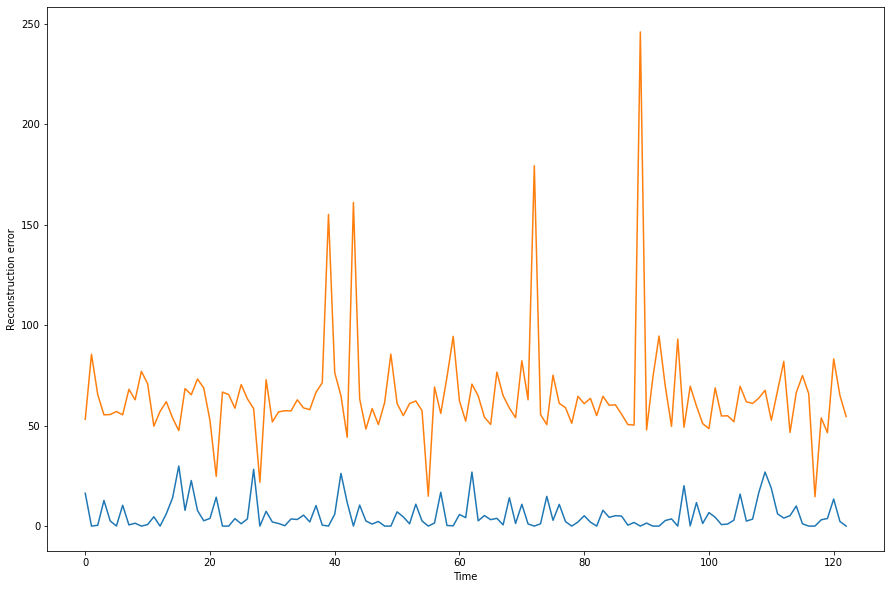

In [79]:
plt.figure(figsize=(15,10))
plt.plot(muni['Mean'])
plt.plot(dates['Mean'])
plt.xlabel("Time")
plt.ylabel("Reconstruction error")
plt.show()

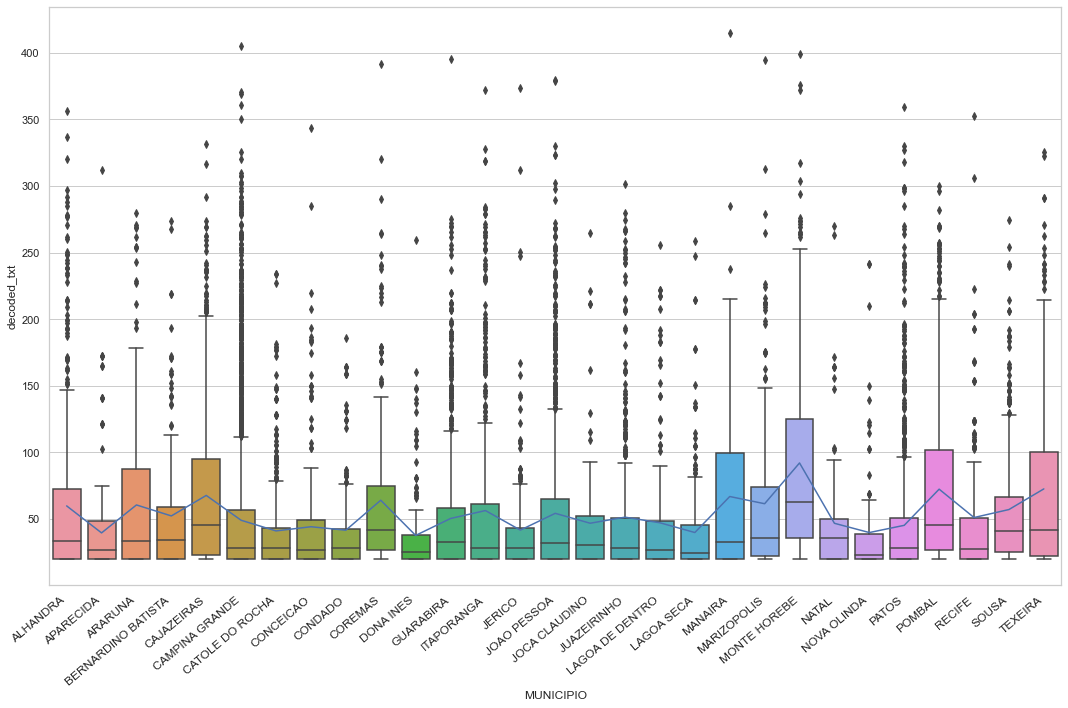

In [171]:
munis_aux = df.groupby('MUNICIPIO')['decoded_txt'].count().reset_index(name ='Total')
munis_aux = munis_aux[munis_aux['Total'] > 100]
munis = df[['MUNICIPIO', 'decoded_txt']]
munis = munis[munis['MUNICIPIO'].isin(munis_aux['MUNICIPIO'])]
munis = munis.sort_values(by=['MUNICIPIO']).reset_index(drop=True)
munis2 = df.groupby('MUNICIPIO')['decoded_txt'].mean().reset_index(name ='Mean')
munis2 = munis2[munis2['MUNICIPIO'].isin(munis_aux['MUNICIPIO'])]
munis2 = munis2.sort_values(by=['MUNICIPIO']).reset_index(drop=True)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,10)) 
boxplot = sns.boxplot(x='MUNICIPIO', y='decoded_txt', data = munis)
barplot = sns.lineplot(x='MUNICIPIO', y='Mean', data = munis2)
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=40, ha="right", fontsize=12)
plt.tight_layout()
plt.show()

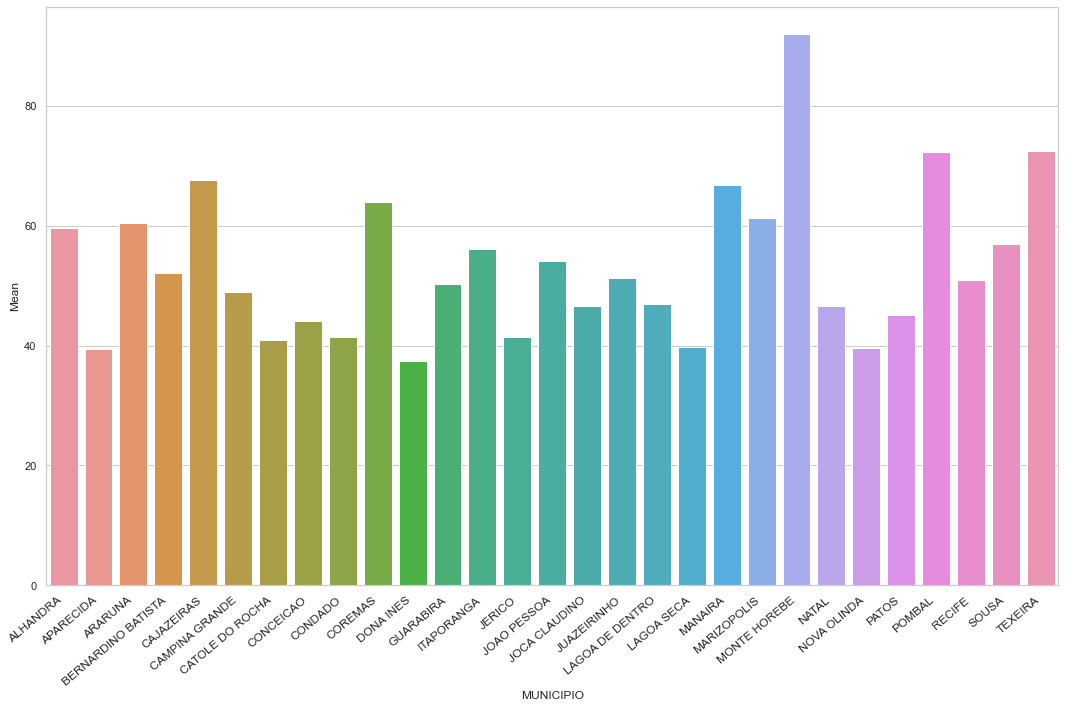

In [164]:
munis_aux = df.groupby('MUNICIPIO')['decoded_txt'].count().reset_index(name ='Total')
munis_aux = munis_aux[munis_aux['Total'] > 100]
munis2 = df.groupby('MUNICIPIO')['decoded_txt'].mean().reset_index(name ='Mean')
munis2 = munis2[munis2['MUNICIPIO'].isin(munis_aux['MUNICIPIO'])]
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,10)) 
barplot = sns.barplot(x='MUNICIPIO', y='Mean', data = munis2)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=40, ha="right", fontsize=12)
plt.tight_layout()
plt.show()

In [61]:
df

,id,Label_1,Label_2,Original,Quantity,Price,MUNICIPIO,Text,decoded_txt,raw
0,15204,2328,704,PANTOPRAZOL 40MG 56DPS,12,421.88,CATOLE DO ROCHA,PANTOPRAZOL 40 56,19.854046,"[64.71314239501953, 29.685192108154297, 6.5136..."
1,15196,2328,704,PANTOPRAZOL 40MG 56DPS,5,421.88,CATOLE DO ROCHA,PANTOPRAZOL 40 56,19.854046,"[64.71314239501953, 29.685192108154297, 6.5136..."
2,15200,2328,704,PANTOPRAZOL 40MG 56DPS,12,421.88,CATOLE DO ROCHA,PANTOPRAZOL 40 56,19.854046,"[64.71314239501953, 29.685192108154297, 6.5136..."
3,15208,2328,704,PANTOPRAZOL 40MG 56DPS,12,421.88,CATOLE DO ROCHA,PANTOPRAZOL 40 56,19.854046,"[64.71314239501953, 29.685192108154297, 6.5136..."
4,15201,2328,704,PANTOPRAZOL 40MG 56DPS,7,421.88,CATOLE DO ROCHA,PANTOPRAZOL 40 56,19.854046,"[64.71314239501953, 29.685192108154297, 6.5136..."
...,...,...,...,...,...,...,...,...,...,...
21111,17832,2737,1342,SNIF SC SPRAY 50 ML,1,20.10,MARIZOPOLIS,SNIF SC 50,394.821869,"[1283.8955078125, 517.5380859375, 72.243576049..."
21112,12992,1899,964,MAGNEN B6 CX 30 COMP REV,1,91.12,GUARABIRA,MAGNEN B6 6 30,395.069946,"[1284.7020263671875, 517.86083984375, 72.28749..."
21113,4151,534,293,CINCHONA OFFICINALIS D1 450ML,2,26.35,MONTE HOREBE,CINCHONA OFFICINALIS 1 450,399.530426,"[1299.2034912109375, 523.665771484375, 73.0771..."
21114,3802,461,257,CATETER INTRAVENOSO 14G HEALCATH,600,1.00,CAMPINA GRANDE,CATETER INTRAVENOSO 14,404.859436,"[1316.5284423828125, 530.6008911132812, 74.020..."


In [60]:
df1 = find_clusters(3273, df.copy())
df2 = find_clusters(1564, df.copy())
label_clusters(df1)
label_clusters(df2)

In [33]:
df1 = df1.sort_values(by=['id']).reset_index(drop=True)
df2 = df2.sort_values(by=['id']).reset_index(drop=True)
df1.to_excel("../dataset/autoencoder_1++.xlsx", index=False)
df2.to_excel("../dataset/autoencoder_2++.xlsx", index=False)

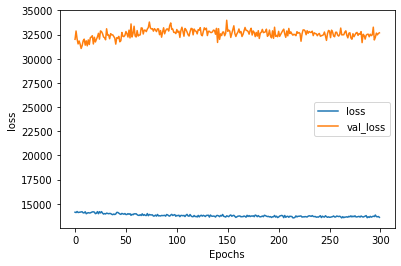

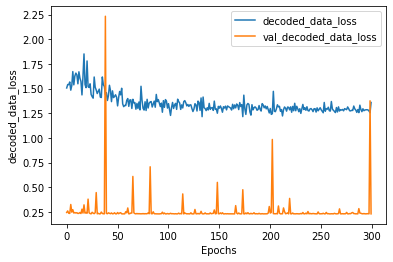

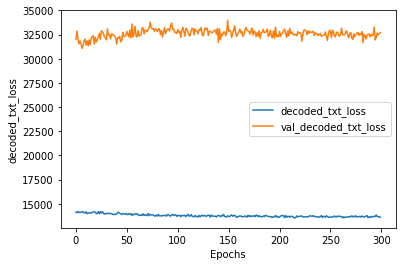

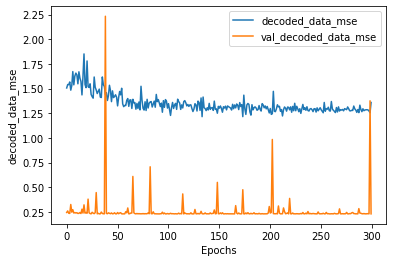

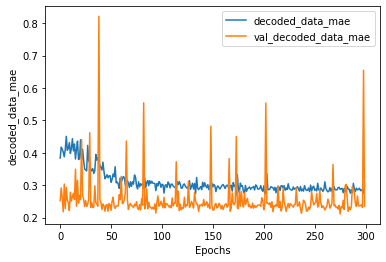

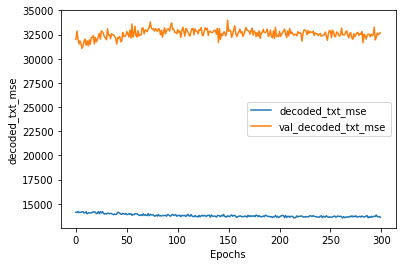

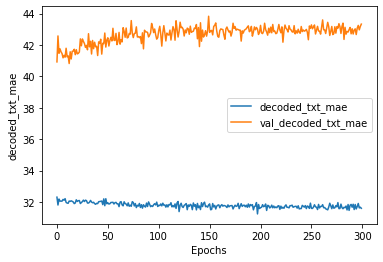

In [34]:
metrics = ['loss', 'decoded_data_loss', 'decoded_txt_loss', 'decoded_data_mse', 'decoded_data_mae', 'decoded_txt_mse', 'decoded_txt_mae']
for metric in metrics:
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plot_name = '../results/' + metric + '.svg'
    plt.savefig(plot_name)
    plt.show()

In [36]:
plt.plot(df['decoded_data'])
plt.xlabel("Dataset row")
plt.ylabel("Reconstruction error")
plt.legend("Reconstruction error increase per row")
plt.show()

KeyError: 'decoded_data'

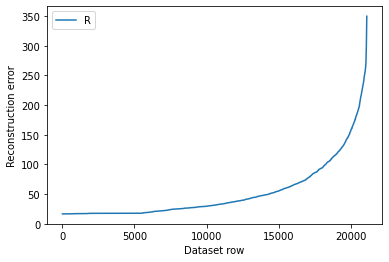

In [38]:
plt.plot(df['decoded_txt'])
plt.xlabel("Dataset row")
plt.ylabel("Reconstruction error")
plt.legend("Reconstruction error increase per row")
plt.show()